### Imports

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from fastai import *
from fastai.vision import *
from fastai.callbacks import *

np.random.seed(42)
torch.cuda.set_device(0)

from annoy import AnnoyIndex

import glob

In [4]:
pd.set_option('display.max_rows', 1000)
pd.set_option('display.max_columns', 1000)

## Creating DFs

In [5]:
#creating df of image names & dataset label (train, val, test)
img_partitions = pd.read_csv('./Eval/list_eval_partition.txt', delim_whitespace=True, header=1)

#creating df of attribute names and type label
attributes = pd.read_csv(
    './Anno/list_attr_cloth.txt', 
    sep='\s{2,}', 
    header=0, 
    skiprows=[0], 
    engine='python')

attributes_imgs = pd.read_csv(
    './Anno/list_attr_img.txt', 
    delim_whitespace=True, 
    header=0,
    skiprows=[0],
    names=(['image_name'] + attributes['attribute_name'].tolist()))
attributes_imgs.replace([-1,0,1],[False,False,True], inplace=True)

#creating df of image names, attribute tags, and dataset label
attributes_df = attributes_imgs.merge(img_partitions, how ='left', on='image_name')

In [6]:
#create list of column names to keep for training
# 1 = Texture, 2 = Fabric, 3 = Shape, 4 = Parts, 5 = Style
list_attr_names = ['image_name']+attributes[(attributes['attribute_type']==2)]['attribute_name'].tolist()
training_df = attributes_df[attributes_df['evaluation_status'].isin(['train','val'])][list_attr_names].copy()
training_df.reset_index(drop=True, inplace=True)

In [7]:
#removing images from DF with no label
training_df['max'] = [training_df.iloc[x][1:].max() for x in training_df.index.tolist()]
training_df = training_df[training_df['max'].isin([True])].copy()
training_df.drop('max', axis=1, inplace=True)

In [8]:
def count_attr_imgs(attr_df):
    col_counts = {}

    for col in attr_df.columns[1:]:
        col_counts[col] = attr_df[col].value_counts().to_frame().loc[True][0]
    
    col_df = pd.DataFrame.from_dict(col_counts, orient='index', columns=['Count'])
    
    return col_df

#.sort_values(by='Count')

## Baseline Model (No Data Cleaning)

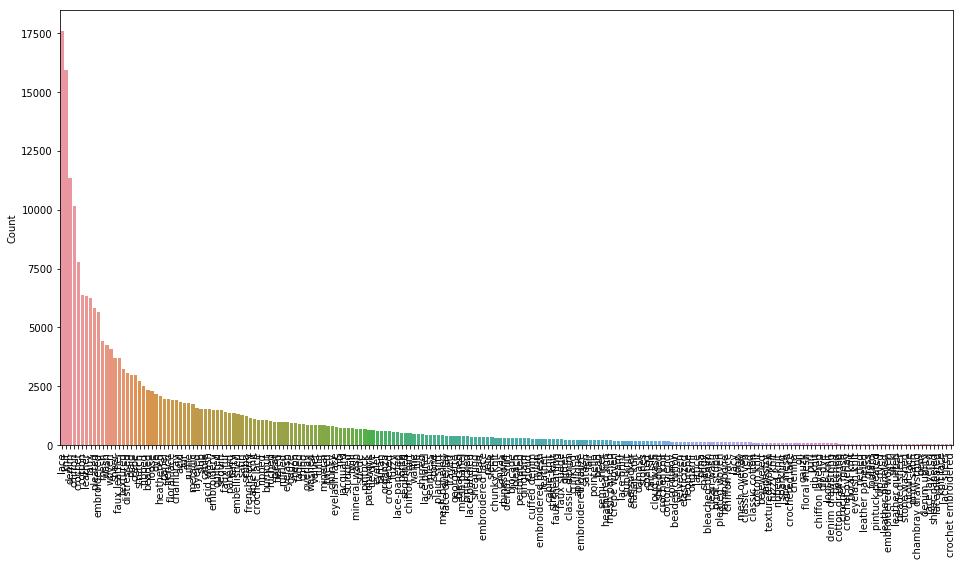

In [11]:
plt.figure(figsize=(16,8))
sns.barplot(x=count_attr_imgs(training_df).sort_values(by='Count',ascending=False).index,y=count_attr_imgs(training_df).sort_values(by='Count',ascending=False)['Count'])
plt.xticks(rotation=90);

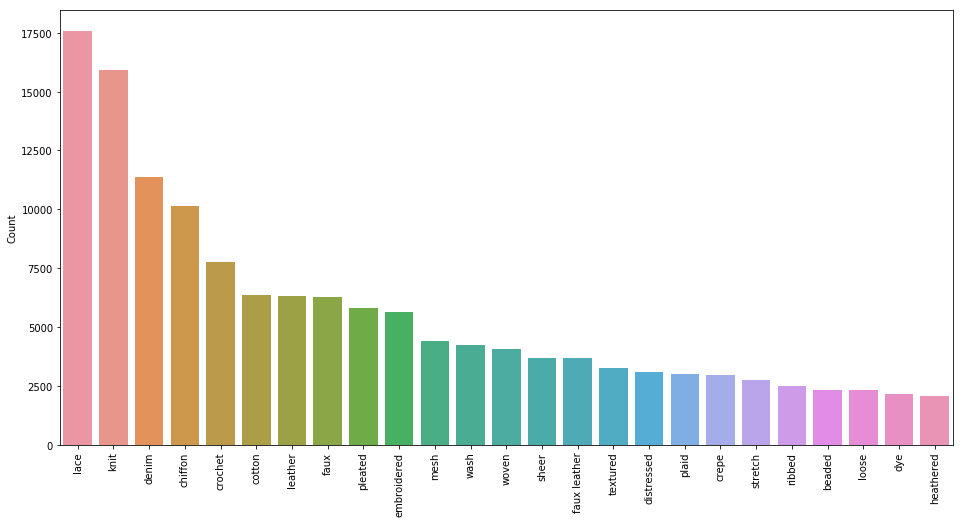

In [12]:
plt.figure(figsize=(16,8))
sns.barplot(x=count_attr_imgs(training_df).sort_values(by='Count',ascending=False)[:25].index,y=count_attr_imgs(training_df).sort_values(by='Count',ascending=False)[:25]['Count'])
plt.xticks(rotation=90);

In [13]:
from fastai import *
from fastai.vision import *

np.random.seed(42)
torch.cuda.set_device(0)

In [14]:
# take all the columns after the first "image_name" col
label_column_names = training_df.columns.tolist()[1:]

img_base_path = Path("./Img/")
data = ImageDataBunch.from_df(img_base_path, training_df, ds_tfms=get_transforms(), size=150, label_col=label_column_names)
data.normalize(imagenet_stats)

ImageDataBunch;

Train: LabelList (105416 items)
x: ImageList
Image (3, 150, 150),Image (3, 150, 150),Image (3, 150, 150),Image (3, 150, 150),Image (3, 150, 150)
y: MultiCategoryList
pleated;sheer,pleated,pleat,pintucked;pleat,sheer
Path: Img;

Valid: LabelList (26354 items)
x: ImageList
Image (3, 150, 150),Image (3, 150, 150),Image (3, 150, 150),Image (3, 150, 150),Image (3, 150, 150)
y: MultiCategoryList
sheer,stretch-knit,classic denim;denim,cable;cable knit;knit,pleat;tweed
Path: Img;

Test: None

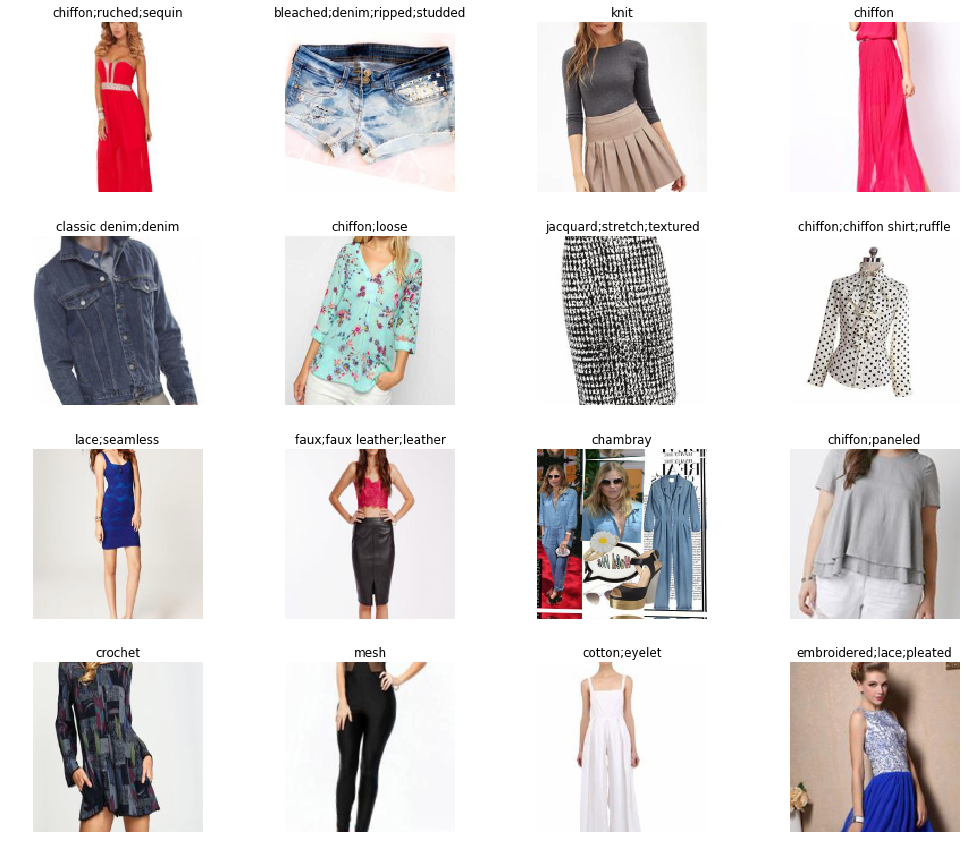

In [17]:
data.show_batch(rows=4, figsize=(14,12))

In [16]:
print(data.classes)
len(data.classes),data.c


['acid', 'acid wash', 'applique', 'bead', 'beaded', 'beaded chiffon', 'beaded sheer', 'bejeweled', 'bleach', 'bleached', 'bleached denim', 'brocade', 'burnout', 'cable', 'cable knit', 'cable-knit', 'canvas', 'chambray', 'chambray drawstring', 'chenille', 'chiffon', 'chiffon lace', 'chiffon layered', 'chiffon shirt', 'chino', 'chunky', 'chunky knit', 'classic cotton', 'classic denim', 'classic knit', 'classic woven', 'clean', 'clean wash', 'cloud', 'cloud wash', 'coated', 'corduroy', 'cotton', 'cotton drawstring', 'cotton knit', 'cotton-blend', 'crepe', 'crepe woven', 'crinkled', 'crochet', 'crochet embroidered', 'crochet knit', 'crochet lace', 'crochet mesh', 'crochet overlay', 'crocheted', 'crocheted lace', 'cuffed denim', 'cutout lace', 'damask', 'denim', 'denim drawstring', 'denim shirt', 'denim utility', 'dip-dye', 'dip-dyed', 'distressed', 'dye', 'elasticized', 'embellished', 'embroidered', 'embroidered gauze', 'embroidered lace', 'embroidered mesh', 'embroidered woven', 'embroide

(218, 218)

In [12]:
acc_02 = partial(accuracy_thresh, thresh=0.1)
f_score = partial(fbeta, thresh=0.1)

In [13]:
learn = cnn_learner(data, models.resnet50, metrics=[acc_02, f_score], callback_fns=ShowGraph)

epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time
0,0.033764,0.032350,0.985991,0.283317,04:22
1,0.031664,0.030658,0.985847,0.319872,04:20
2,0.030820,0.029961,0.987027,0.331219,04:18
3,0.030224,0.029482,0.986446,0.342703,04:22
4,0.029906,0.029345,0.985946,0.350114,04:22


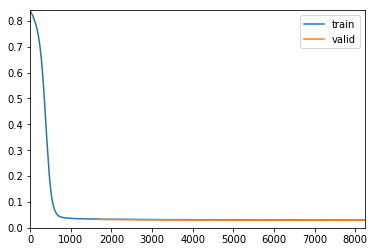

In [14]:
learn.fit_one_cycle(5)

In [15]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


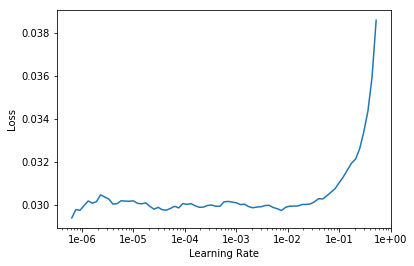

In [16]:
learn.recorder.plot()

In [17]:
learn.unfreeze()

epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time
0,0.030486,0.029395,0.985783,0.355099,05:44
1,0.029321,0.028421,0.986744,0.371200,05:44
2,0.028093,0.027476,0.986072,0.396946,05:44
3,0.026780,0.027251,0.986352,0.404322,05:43


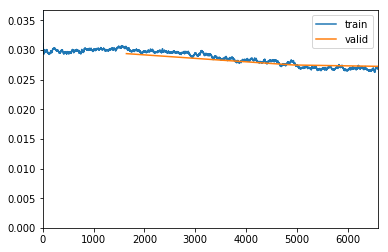

In [18]:
learn.fit_one_cycle(4, slice(1e-5,1e-3))

In [20]:
learn.save('fabric-resnet50-size150-fr5-unfr4', return_path=True)
learn.export('fabric-resnet50-size150-fr5-unfr4.pkl')

In [23]:
learn = load_learner('Img/','fabric-resnet50-size150-fr5-unfr4.pkl')

[('pleated', 0.3133130371570587), ('chiffon', 0.15380294620990753), ('leather', 0.04804735630750656), ('lace', 0.04202505201101303), ('knit', 0.03583695739507675)]


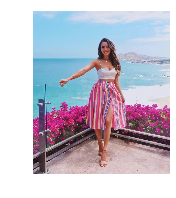

In [25]:
predict_img_path = "pink.jpg" 
category,classIndex,losses = learn.predict(open_image(predict_img_path))
predictions = sorted(zip(data.classes, map(float, losses)), key=lambda p: p[1], reverse=True)
print (predictions[:5])
show_image(open_image(predict_img_path))

# "/data/Michael/data/predict/2.png"